In [87]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations


# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import homemade functions:
from MAPseq_processing import *
from MAPseq_plotting import *

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")
# omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")


# Preprocessing/sorting
## initial processing - OMC


In [3]:

# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

# seperate then concatenate by species
mm_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="MMus"]
st_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="STeg"]
mm_it_all = pd.concat(mm_it)
st_it_all = pd.concat(st_it)

mm_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="MMus"]
st_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="STeg"]
mm_pt_all = pd.concat(mm_pt)
st_pt_all = pd.concat(st_pt)


# IT Motifs

## Individual analysis - keep by animal numbers
- Calculate N_totals
- calculate Obs_proportion
- Calculate cal_proportion (based on independence)
- Plot Fold changes (normalized to MMus mean)

In [4]:
plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)
it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [5]:
grouped = it_motifs_df.groupby(["motifs", "species"])
p_obs_avg = grouped['p_obs'].mean()
p_obs_fc = p_obs_avg[:,"STeg"]/p_obs_avg[:,"MMus"]
fc_order = p_obs_fc.sort_values(ascending=False).index
fc_order

Index(['AUD_', 'AUD_OMCc_', 'AUD_STR_', 'AUD_OMCc_STR_', 'OMCc_', 'OMCc_STR_',
       'STR_'],
      dtype='object', name='motifs')

In [6]:

mmus_avg = p_obs_avg[:, "MMus"]
for i in range(it_motifs_df.shape[0]):
    motif = it_motifs_df.loc[i, "motifs"]
    p_obs = it_motifs_df.loc[i, "p_obs"]
    norm = mmus_avg[motif]
    it_motifs_df.loc[i,"p_obs_norm"] = p_obs/norm
it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus,1.453454
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus,0.322116
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus,1.456115
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus,0.311542
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus,0.782728
...,...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg,0.267243
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg,5.917903
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg,1.059355
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg,2.026643


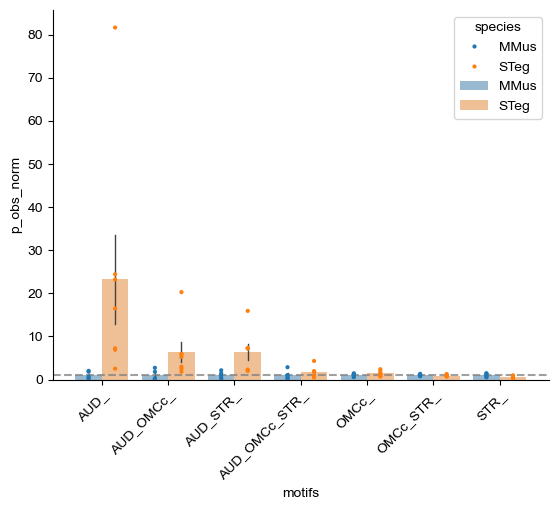

In [7]:
dot_bar_plot(it_motifs_df, xaxis="motifs", yaxis="p_obs_norm",
             hueaxis="species", order = fc_order)
# plt.yscale("log")
plt.axline((0,1), (1,1), color="gray", linestyle="--", alpha=0.75)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [92]:
plot_it_sorted = it_motifs_df.sort_values(by=["motifs"]).reset_index(drop=True)
plot_it_sorted

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,AUD_,11521,11853,8,0.000675,0.000859,MMF3,MMus,0.648525
1,AUD_,380,381,1,0.002625,0.000365,STM5,STeg,2.521972
2,AUD_,15256,15349,3,0.000195,0.000058,MMF5,MMus,0.187805
3,AUD_,535,555,4,0.007207,0.004604,STM1,STeg,6.925198
4,AUD_,443,472,12,0.025424,0.009641,STM2,STeg,24.428931
...,...,...,...,...,...,...,...,...,...
79,STR_,675,699,100,0.143062,0.146161,STF4,STeg,0.698726
80,STR_,527,530,29,0.054717,0.053811,STM7,STeg,0.267243
81,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus,1.456115
82,STR_,306,331,53,0.160121,0.187324,STF3,STeg,0.782046


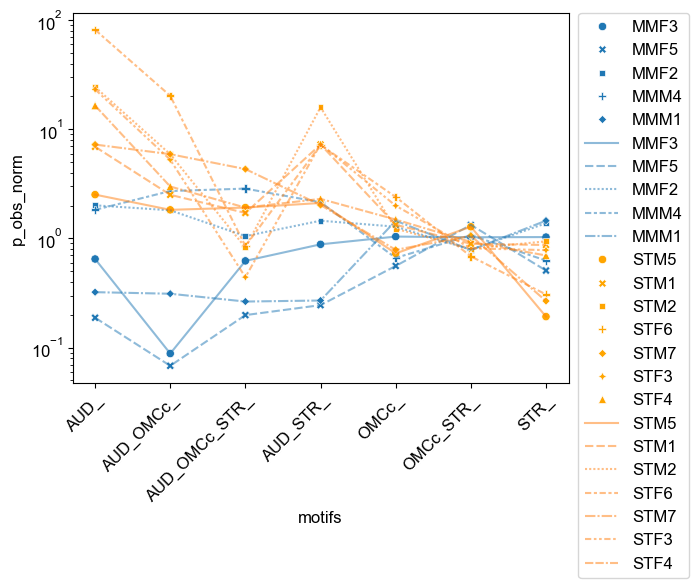

In [93]:
individ_node_plot(plot_it_sorted, xaxis="motifs", yaxis="p_obs_norm")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.yscale("log")
plt.show()

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:379: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$log_{2}$($\dfrac{STeg}{MMus}$)')
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:382: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel('$-log_{10}(p\ value)$')
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:496: SyntaxWarning: invalid escape sequence '\M'
  plt.ylabel("Log2(r'\frac{Steg}{\MMus}$')")


<Axes: xlabel='motifs', ylabel='p_obs'>

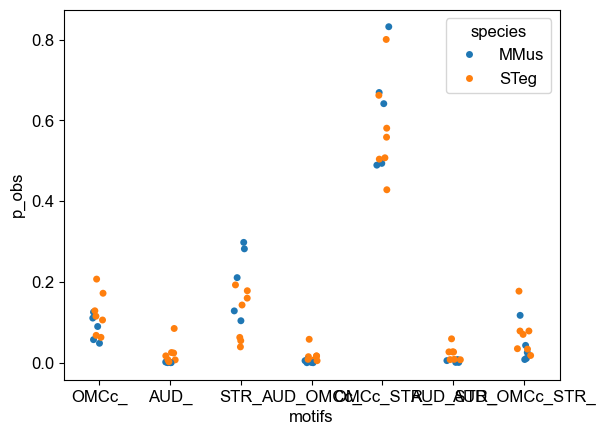

In [90]:
individual_mice_plot(it_motifs_df)

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  # plot unity line


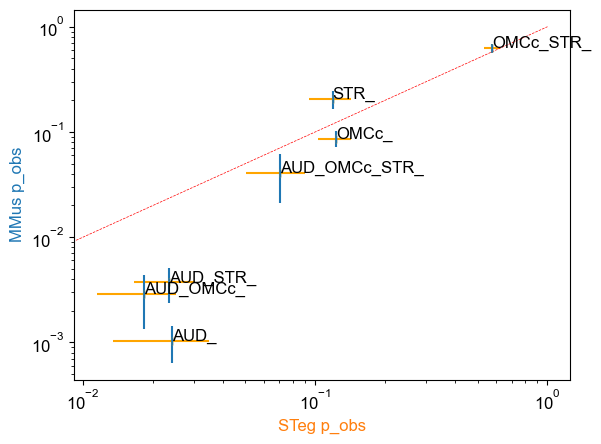

In [139]:
# scatterplot
stvmm_area_scatter(it_motifs_df, to_plot="p_obs", groupby="motifs", log=True)
plt.show()

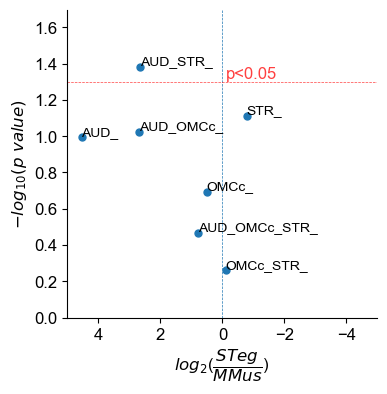

In [137]:
# volcano plot
ttest = proportion_ttest(it_motifs_df, to_plot="p_obs", groupby="motifs")
plot_volcano(ttest, labels="motifs", p_01=False, xlim=(5,-5), legend_loc=None)
plt.show()

## Scatter plot(s)

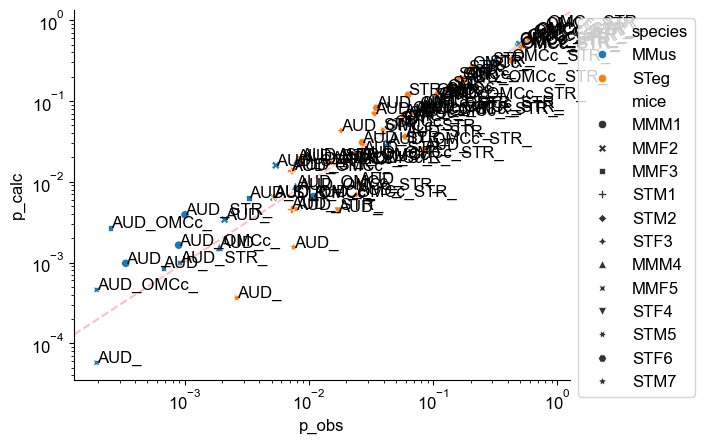

In [313]:
# generate obs vs calc plot
sns.scatterplot(it_motifs_df, x="p_obs", y="p_calc", hue="species", 
                style="mice")
# add labels
for index, row in it_motifs_df.iterrows():
    plt.text(row["p_obs"], row["p_calc"], row["motifs"])
plt.legend(bbox_to_anchor=(1,1))
plt.axline((0,0), (0.4,0.4), color="red", linestyle="--", alpha=0.25)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xscale("log")
plt.yscale("log")
plt.show()

## Generate plot per motif

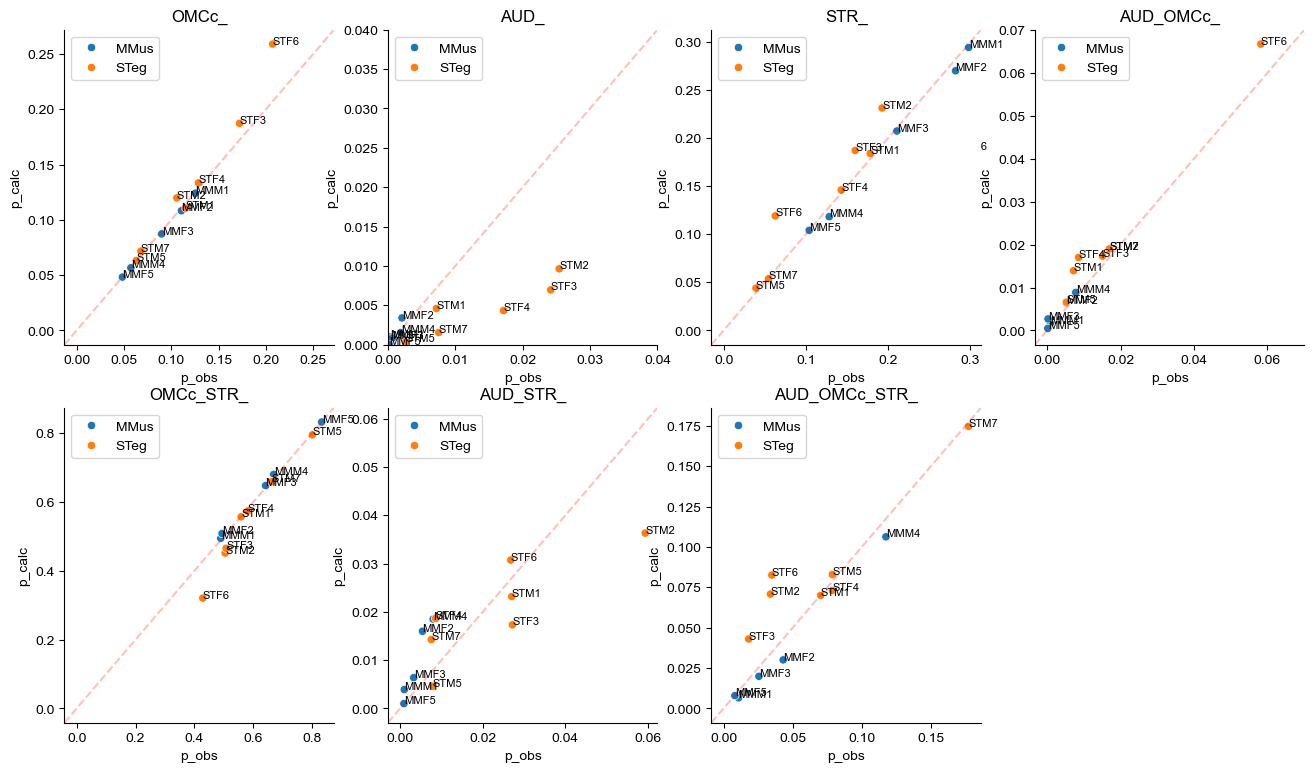

In [20]:
# generate obs vs calc plot

fig, axs = plt.subplots(2,4, figsize=(16,9))

i=0
for motif in it_motifs_df["motifs"].unique():
    plot_df = it_motifs_df[it_motifs_df["motifs"]==motif]

    # get max bounds for y=x line
    obs = plot_df["p_obs"].max()
    calc = plot_df["p_calc"].max()
    if obs>=calc:
        max_p = obs
    else:
        max_p = calc

    ax = axs.flat[i]
    sns.scatterplot(plot_df, x="p_obs", y="p_calc", hue="species", ax=ax)
    ax.legend()
    ax.axline((0,0), (max_p, max_p), color="red", linestyle="--", alpha=0.25)
    ax.set_title(motif)
    i+=1
    # # add labels
    for index, row in plot_df.iterrows():
        ax.text(row["p_obs"], row["p_calc"], row["mice"], size=8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.set_xscale("log")
    # ax.set_yscale("log")

    if motif=="AUD_":
        ax.set_xlim(0,0.04)
        ax.set_ylim(0,0.04)

axs.flat[7].axis("off")

plt.show()

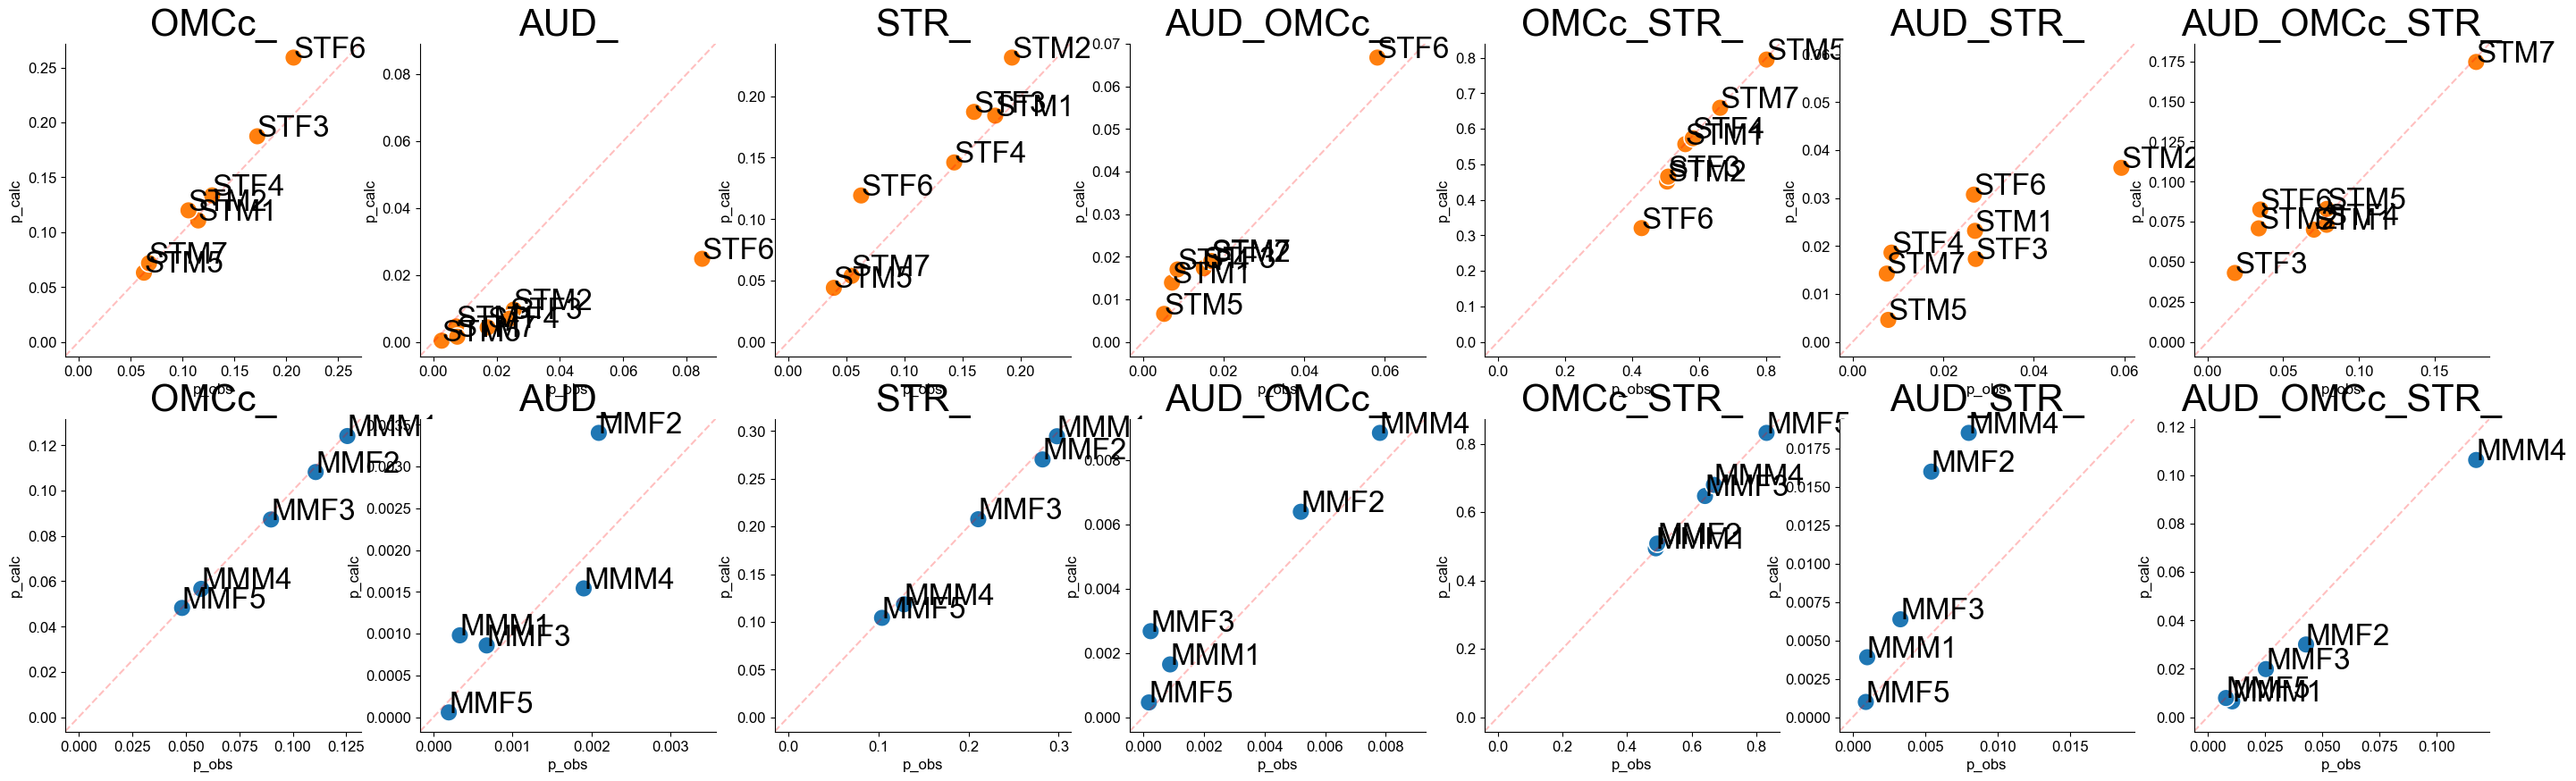

In [120]:
# generate obs vs calc plot - row of steg and row of mmus

# fig, axs = plt.subplots(2,7, figsize=(35,10))

i=0
for sp in ["STeg", "MMus"]:
    sp_df = it_motifs_df[it_motifs_df["species"]==sp]
    for motif in sp_df["motifs"].unique():
        plot_df = sp_df[sp_df["motifs"]==motif]

        # get max bounds for y=x line
        obs = plot_df["p_obs"].max()
        calc = plot_df["p_calc"].max()
        if obs>=calc:
            max_p = obs
        else:
            max_p = calc

        ax = axs.flat[i]
        if sp=="STeg":
            col = "tab:orange"
        else:
            col = "tab:blue"
        sns.scatterplot(plot_df, x="p_obs", y="p_calc", hue="species", ax=ax,
                        palette=dict(STeg="tab:orange", MMus="tab:blue"), legend=False, s=200)
        ax.axline((0,0), (max_p, max_p), color="red", linestyle="--", alpha=0.25)
        ax.set_title(motif, size=30)
        i+=1
        # # add labels
        for index, row in plot_df.iterrows():
            ax.text(row["p_obs"], row["p_calc"], row["mice"], size=24)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ax.set_xscale("log")
        # ax.set_yscale("log")

        # if motif=="AUD_":
        #     ax.set_xlim(0,0.04)
        #     ax.set_ylim(0,0.04)


# plt.savefig(out_path+"obs_v_calc_it_all.svg", dpi=300, bbox_inches="tight`")
plt.show()

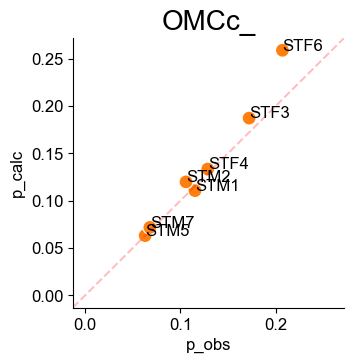

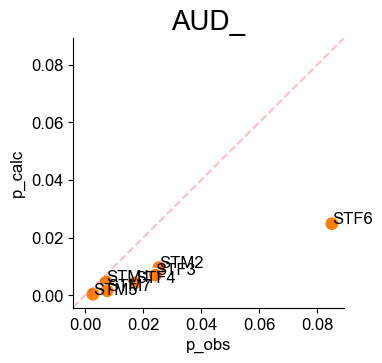

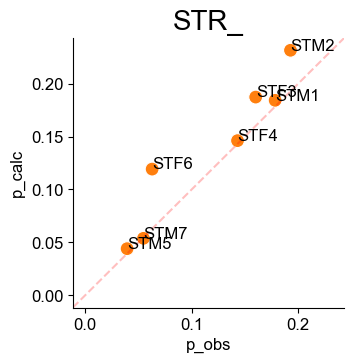

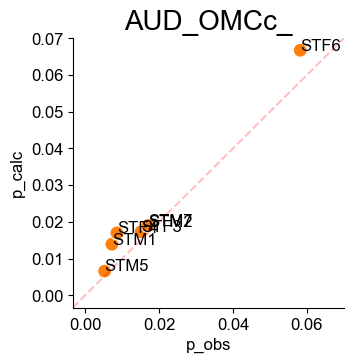

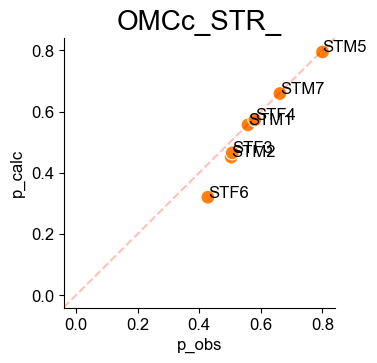

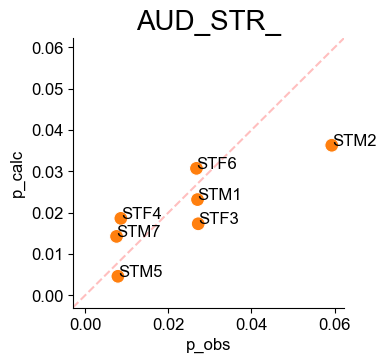

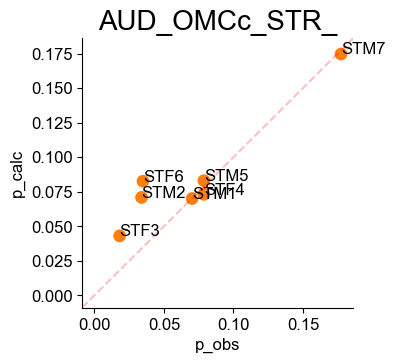

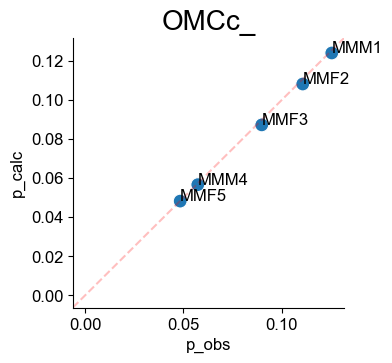

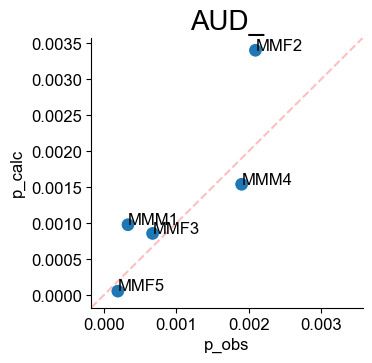

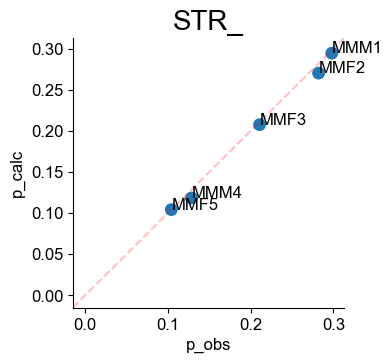

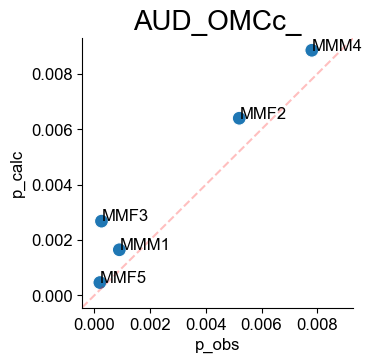

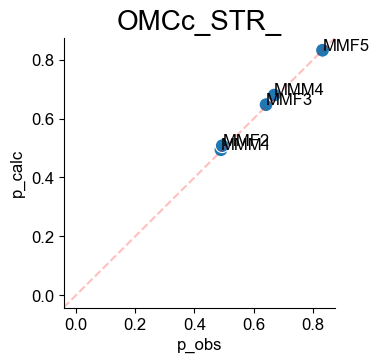

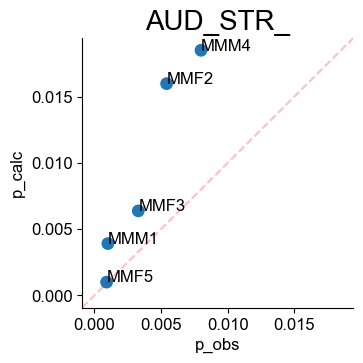

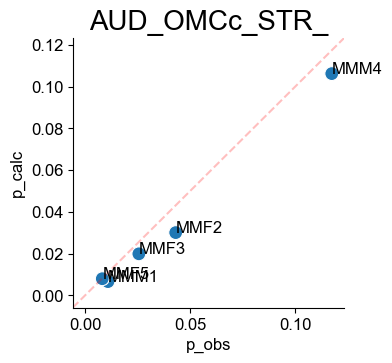

In [222]:
# generate obs vs calc plot - row of steg and row of mmus

# fig, axs = plt.subplots(2,7, figsize=(35,10))

i=0
for sp in ["STeg", "MMus"]:
    sp_df = it_motifs_df[it_motifs_df["species"]==sp]
    for motif in sp_df["motifs"].unique():
        plot_df = sp_df[sp_df["motifs"]==motif]

        # get max bounds for y=x line
        obs = plot_df["p_obs"].max()
        calc = plot_df["p_calc"].max()
        if obs>=calc:
            max_p = obs
        else:
            max_p = calc

        # ax = axs.flat[i]
        if sp=="STeg":
            col = "tab:orange"
        else:
            col = "tab:blue"
            
        sns.scatterplot(plot_df, x="p_obs", y="p_calc", hue="species",
                        palette=dict(STeg="tab:orange", MMus="tab:blue"), legend=False, s=100)
        plt.axline((0,0), (max_p, max_p), color="red", linestyle="--", alpha=0.25)
        plt.title(motif, size=20)
        i+=1
        # # add labels
        for index, row in plot_df.iterrows():
            plt.text(row["p_obs"], row["p_calc"], row["mice"])

        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        fig = plt.gcf()
        fig.set_size_inches(3.5,3.5)
        # ax.set_xscale("log")
        # ax.set_yscale("log")

        # if motif=="AUD_":
        #     ax.set_xlim(0,0.04)
        #     ax.set_ylim(0,0.04)


        plt.savefig(out_path+"obs_v_calc_it_"+sp+"_"+motif+".svg", dpi=300, bbox_inches="tight")
        plt.show()

In [151]:
test = it_motifs_df["motifs"]
test

0             OMCc_
1              AUD_
2              STR_
3         AUD_OMCc_
4         OMCc_STR_
          ...      
79             STR_
80        AUD_OMCc_
81        OMCc_STR_
82         AUD_STR_
83    AUD_OMCc_STR_
Name: motifs, Length: 84, dtype: object

In [202]:
stacked_df = pd.DataFrame(columns=["mice", "species", "motifs", "p_obs"])

for j in range(metadata.shape[0]):
    mice_df = it_motifs_df[it_motifs_df["mice"]==metadata.loc[j,"mice"]].reset_index(drop=True)
    plot = []
    for i in range(mice_df.shape[0]):
        pob = mice_df.loc[i,"p_obs"]
        if i > 0:
            summary = mice_df.loc[0:i-1, "p_obs"].sum()
        else:
            summary = 0
        plot.append(summary+pob)
        if i==6:
            plot.append(1)

    mice_df.loc[7, "motifs"] = "empty"


    int_df = pd.DataFrame({"mice":metadata.loc[j,"mice"], "species":metadata.loc[j,"species"],
                           "motifs":mice_df["motifs"], "p_obs":plot})

    stacked_df = pd.concat([stacked_df, int_df]).reset_index(drop=True)
stacked_df

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_63586/3273405988.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stacked_df = pd.concat([stacked_df, int_df]).reset_index(drop=True)


,mice,species,motifs,p_obs
0,MMM1,MMus,OMCc_,0.125489
1,MMM1,MMus,AUD_,0.125824
2,MMM1,MMus,STR_,0.423958
3,MMM1,MMus,AUD_OMCc_,0.424852
4,MMM1,MMus,OMCc_STR_,0.914180
...,...,...,...,...
91,STM7,STeg,AUD_OMCc_,0.147170
92,STM7,STeg,OMCc_STR_,0.809434
93,STM7,STeg,AUD_STR_,0.816981
94,STM7,STeg,AUD_OMCc_STR_,0.994340


In [206]:
# mot_order = list(fc_order)
# mot_order.append("_")
# mot_order
mot_order = stacked_df["motifs"].unique()
# mot_order = np.flip(mot_order)

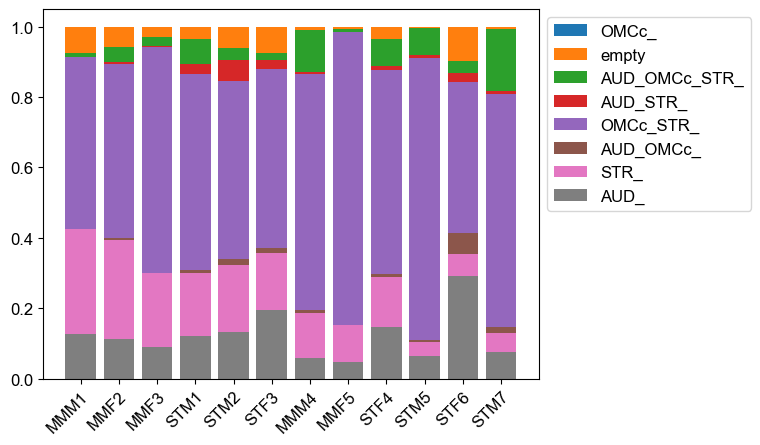

In [212]:
# colors = ["r", "b", "g", "y", "w", "r", "b", "g"]
for i in range(len(mot_order)):
    int_pl = stacked_df[stacked_df["motifs"]==mot_order[-i]]
    plt.bar(int_pl["mice"], int_pl["p_obs"], label=mot_order[-i])

plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.show()

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus,1.453454
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus,0.322116
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus,1.456115
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus,0.311542
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus,0.782728
5,AUD_STR_,8287,8949,9,0.001006,0.003903,MMM1,MMus,0.270060
6,AUD_OMCc_STR_,8287,8949,97,0.010839,0.006548,MMM1,MMus,0.264220


In [28]:
motif_strings

['OMCc_',
 'AUD_',
 'STR_',
 'AUD_OMCc_',
 'OMCc_STR_',
 'AUD_STR_',
 'AUD_OMCc_STR_']

In [36]:
it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus,1.453454
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus,0.322116
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus,1.456115
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus,0.311542
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus,0.782728
...,...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg,0.267243
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg,5.917903
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg,1.059355
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg,2.026643


In [37]:
it_motifs_df[(it_motifs_df["motifs"]=="AUD_") & (it_motifs_df["species"]=="MMus")]

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus,0.322116
8,AUD_,13050,13847,29,0.002094,0.003403,MMF2,MMus,2.012369
15,AUD_,11521,11853,8,0.000675,0.000859,MMF3,MMus,0.648525
43,AUD_,5201,5253,10,0.001904,0.001542,MMM4,MMus,1.829186
50,AUD_,15256,15349,3,0.000195,0.000058,MMF5,MMus,0.187805


In [47]:
# Paired t-test calculated/estimated vs. observed
from scipy.stats import ttest_rel

rel_ttest_df = pd.DataFrame(columns=["motifs", "species", "ttest","pval", "pobs_mean", "pcalc_mean"])

i=0
for sp in ["MMus", "STeg"]:
    for motif in motif_strings:
        subset = it_motifs_df[(it_motifs_df["motifs"]==motif) & (it_motifs_df["species"]==sp)]
        pobs_avg = subset["p_obs"].mean()
        pcalc_avg = subset["p_calc"].mean()
        ttest = ttest_rel(subset["p_calc"], subset["p_obs"])
        rel_ttest_df.loc[i,:] = [motif, sp, ttest.statistic, ttest.pvalue, pobs_avg, pcalc_avg]
        i+=1

# aud = it_motifs_df[it_motifs_df["motifs"]=="AUD_"]
# aud_mm = aud[aud["species"]=="MMus"]
# aud_st = aud[aud["species"]=="STeg"]

# aud_st_ttest = ttest_rel(aud_st["p_calc"], aud_st["p_obs"])
# rel_ttest_df.loc[0,:] = ["AUD", "STeg", aud_st_ttest.statistic, aud_st_ttest.pvalue]
rel_ttest_df

,motifs,species,ttest,pval,pobs_mean,pcalc_mean
0,OMCc_,MMus,-2.940472,0.042369,0.086338,0.084891
1,AUD_,MMus,1.098936,0.333496,0.001041,0.001368
2,STR_,MMus,-2.544742,0.06366,0.204746,0.19901
3,AUD_OMCc_,MMus,3.164699,0.03403,0.002869,0.004007
4,OMCc_STR_,MMus,2.90915,0.043715,0.625158,0.632359
5,AUD_STR_,MMus,2.520842,0.065298,0.003724,0.00915
6,AUD_OMCc_STR_,MMus,-2.944345,0.042206,0.041023,0.034132
7,OMCc_,STeg,1.695883,0.140838,0.122906,0.13501
8,AUD_,STeg,-2.196261,0.070464,0.02416,0.007473
9,STR_,STeg,2.329924,0.058647,0.118758,0.138059


In [67]:
# log2fc
fc = rel_ttest_df["pobs_mean"]/rel_ttest_df["pcalc_mean"]
rel_ttest_df["log2fc_obs/calc"] = np.log2(fc.astype(float))
rel_ttest_df["nlog10_p"] = -1*np.log10(rel_ttest_df["pval"].astype(float))
rel_ttest_df


,motifs,species,ttest,pval,pobs_mean,pcalc_mean,fc_obs_calc,log2fc_obs/calc,nlog10_p
0,OMCc_,MMus,-2.940472,0.042369,0.086338,0.084891,1.017046,0.024385,1.372950
1,AUD_,MMus,1.098936,0.333496,0.001041,0.001368,0.76065,-0.394695,0.476909
2,STR_,MMus,-2.544742,0.06366,0.204746,0.19901,1.028823,0.040995,1.196136
3,AUD_OMCc_,MMus,3.164699,0.03403,0.002869,0.004007,0.716152,-0.481662,1.468134
4,OMCc_STR_,MMus,2.90915,0.043715,0.625158,0.632359,0.988613,-0.016523,1.359366
5,AUD_STR_,MMus,2.520842,0.065298,0.003724,0.00915,0.406981,-1.296968,1.185099
6,AUD_OMCc_STR_,MMus,-2.944345,0.042206,0.041023,0.034132,1.201893,0.265308,1.374624
7,OMCc_,STeg,1.695883,0.140838,0.122906,0.13501,0.910348,-0.135509,0.851281
8,AUD_,STeg,-2.196261,0.070464,0.02416,0.007473,3.233173,1.692951,1.152031
9,STR_,STeg,2.329924,0.058647,0.118758,0.138059,0.860199,-0.217258,1.231756


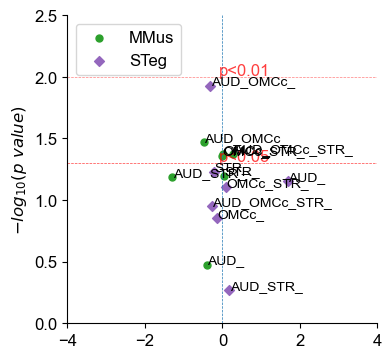

In [75]:
plot_volcano(rel_ttest_df, x="log2fc_obs/calc", y="nlog10_p", labels="motifs", shape="species")
plt.xlim(-4,4)
plt.ylim(0,2.5)
plt.show()

In [58]:
type(rel_ttest_df["fc_obs_calc"])

pandas.core.series.Series

## Simulated data

In [153]:
# generate simulated data
sim_avgs = []
sim_stds = []
for i in range(len(omc_it)):
    foo, shuffle_prob_reps = motif_simulation(omc_it[i], adjust_total=True)
    shuffled_array = np.array(shuffle_prob_reps)
    sim_avgs.append(shuffled_array.mean(axis=0))
    sim_stds.append(shuffled_array.std(axis=0))


it_motifs_df["p_sim"] = np.array(sim_avgs).flatten()
it_motifs_df["p_sim_std"] = np.array(sim_stds).flatten()
it_motifs_df

<Axes: xlabel='p_calc', ylabel='p_sim'>

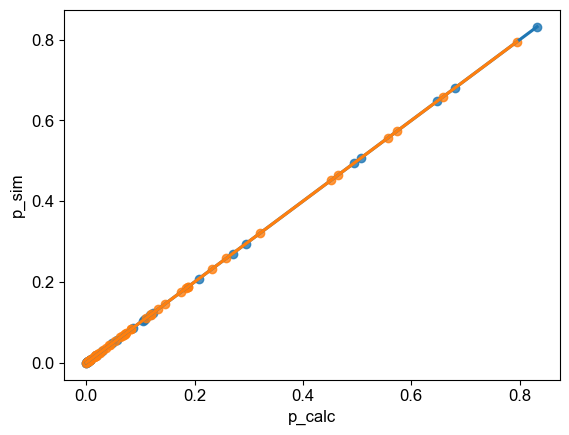

In [319]:
# plot calc vs. sim
# sns.lineplot(it_motifs_df, x="p_obs", y="p_sim", hue="species")
# sns.lineplot(it_motifs_df, x="p_obs", y="p_calc", hue="species")
mm = it_motifs_df[it_motifs_df["species"]=="MMus"]
st = it_motifs_df[it_motifs_df["species"]=="STeg"]

sns.regplot(mm, x="p_calc", y="p_sim", n_boot=100)
sns.regplot(st, x="p_calc", y="p_sim", n_boot=100)

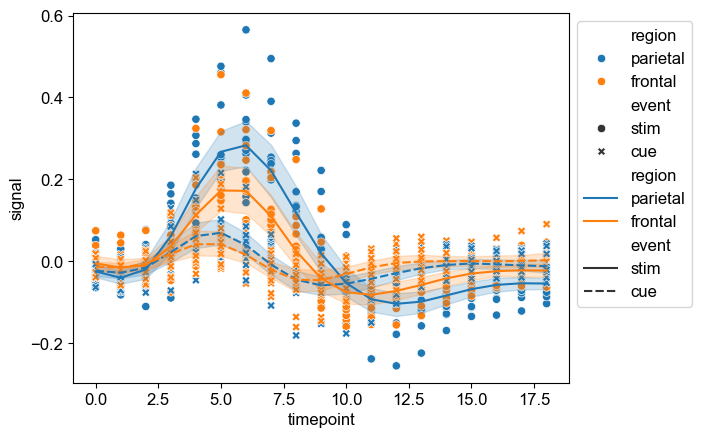

In [192]:

# # Load an example dataset with long-form data
# fmri = sns.load_dataset("fmri")

# # Plot the responses for different events and regions
# sns.scatterplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=fmri)
# sns.lineplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=fmri)
# plt.legend(_to_anchobboxr=(1,1))
# plt.show()

# PT Motifs

### Apply $N_{total}$ calculation to real data

- Taken from Methods section of Han et al., 2017
$$
\frac{N_{obs}}{N_{total}} + \Pi_{i=1}^k(1-\frac{N_{Ai}}{N_{total}}) = 1
$$
For 8 areas, k=8, then expand that to:
$$
(N_{obs}-N_{A1}....-N_{A8})N_{total}^{7} + (N_{A1}N_{A2} + N_{A1}N_{A3}....N_{A7}N_{A8})N_{total}^{6} - (N_{A1}N_{A2}N_{A3}...N_{A6}N_{A7}N_{A8})N_{total}^{5}....+(N_{A1}N_{A2}N_{A3}N_{A4}N_{A5}N_{A6}N_{A7}N_{A8}) = 0
$$

## individual mice

In [193]:
plot_areas = plot_areas = ['TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']

# Estimate n-totals
n_totals = [estimate_n_total(omc_pt[i], plot_areas) for i in range(len(omc_pt))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_pt]
motifs = n_obs_motifs[0].index

# convert to proportions
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_pt]

motif_strings = TF_to_motifs(motifs)

# put into dataframe
pt_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_pt[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    pt_motifs_df.append(df)
pt_motifs_df = pd.concat(pt_motifs_df).reset_index(drop=True)
pt_motifs_df


,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,TH_,1313,1318,0,0.000000,0.004903,MMM1,MMus
1,HY_,1313,1318,42,0.031866,0.023978,MMM1,MMus
2,AMY_,1313,1318,3,0.002276,0.000329,MMM1,MMus
3,SNr_,1313,1318,15,0.011381,0.003772,MMM1,MMus
4,SCm_,1313,1318,6,0.004552,0.001065,MMM1,MMus
...,...,...,...,...,...,...,...,...
3055,AMY_BS_HY_PAG_PG_SCm_TH_,216,216,1,0.004630,0.002629,STM7,STeg
3056,BS_HY_PAG_PG_SCm_SNr_TH_,216,216,1,0.004630,0.001936,STM7,STeg
3057,AMY_BS_PAG_PG_SCm_SNr_TH_,216,216,8,0.037037,0.012738,STM7,STeg
3058,AMY_BS_HY_PAG_PG_SCm_SNr_,216,216,3,0.013889,0.004618,STM7,STeg


In [195]:
print([df.shape[0] for df in omc_pt])
print(n_totals)

[1313, 2198, 1610, 93, 47, 70, 1171, 2967, 211, 119, 225, 216]
[1318, 2208, 1618, 94, 48, 71, 1185, 2969, 214, 119, 229, 216]


In [240]:

grouped = pt_motifs_df.groupby(["motifs", "species"])
p_obs_avg = grouped['p_obs'].mean()
p_obs_fc = p_obs_avg[:,"STeg"]/p_obs_avg[:,"MMus"]
fc_order = p_obs_fc.sort_values(ascending=False).index

mm = pt_motifs_df[pt_motifs_df["species"]=="MMus"]
mm_avg = mm.groupby("motifs")["p_obs"].mean()
idx = p_obs_avg[:,"MMus"]!=0
index = p_obs_avg[:,"MMus"].index
keep_motifs = index[idx.values]

In [247]:
fc_order = fc_order[fc_order.isin(keep_motifs)]

In [244]:
pt_motifs_df_select = pt_motifs_df[pt_motifs_df["motifs"].isin(keep_motifs)]
pt_motifs_df_select = pt_motifs_df_select.reset_index(drop=True)
pt_motifs_df_select

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,HY_,1313,1318,42,0.031866,0.023978,MMM1,MMus,1.245777
1,AMY_,1313,1318,3,0.002276,0.000329,MMM1,MMus,0.033872
2,SNr_,1313,1318,15,0.011381,0.003772,MMM1,MMus,0.807606
3,SCm_,1313,1318,6,0.004552,0.001065,MMM1,MMus,0.334408
4,PG_,1313,1318,48,0.036419,0.012869,MMM1,MMus,2.116031
...,...,...,...,...,...,...,...,...,...
1783,AMY_HY_PAG_PG_SCm_SNr_TH_,216,216,9,0.041667,0.012214,STM7,STeg,15.791836
1784,AMY_BS_HY_PG_SCm_SNr_TH_,216,216,0,0.000000,0.002990,STM7,STeg,0.000000
1785,AMY_BS_HY_PAG_PG_SNr_TH_,216,216,11,0.050926,0.006577,STM7,STeg,301.736111
1786,BS_HY_PAG_PG_SCm_SNr_TH_,216,216,1,0.004630,0.001936,STM7,STeg,0.562571


In [245]:

mmus_avg = p_obs_avg[:, "MMus"]
for i in range(pt_motifs_df_select.shape[0]):
    motif = pt_motifs_df.loc[i, "motifs"]
    p_obs = pt_motifs_df.loc[i, "p_obs"]
    norm = mmus_avg[motif]
    pt_motifs_df_select.loc[i,"p_obs_norm"] = p_obs/norm
pt_motifs_df_select


/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_38282/33160178.py:6: RuntimeWarning: invalid value encountered in scalar divide
  pt_motifs_df_select.loc[i,"p_obs_norm"] = p_obs/norm
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_38282/33160178.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  pt_motifs_df_select.loc[i,"p_obs_norm"] = p_obs/norm


,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,p_obs_norm
0,HY_,1313,1318,42,0.031866,0.023978,MMM1,MMus,NaN
1,AMY_,1313,1318,3,0.002276,0.000329,MMM1,MMus,1.245777
2,SNr_,1313,1318,15,0.011381,0.003772,MMM1,MMus,0.033872
3,SCm_,1313,1318,6,0.004552,0.001065,MMM1,MMus,0.807606
4,PG_,1313,1318,48,0.036419,0.012869,MMM1,MMus,0.334408
...,...,...,...,...,...,...,...,...,...
1783,AMY_HY_PAG_PG_SCm_SNr_TH_,216,216,9,0.041667,0.012214,STM7,STeg,NaN
1784,AMY_BS_HY_PG_SCm_SNr_TH_,216,216,0,0.000000,0.002990,STM7,STeg,5.000000
1785,AMY_BS_HY_PAG_PG_SNr_TH_,216,216,11,0.050926,0.006577,STM7,STeg,NaN
1786,BS_HY_PAG_PG_SCm_SNr_TH_,216,216,1,0.004630,0.001936,STM7,STeg,0.105338


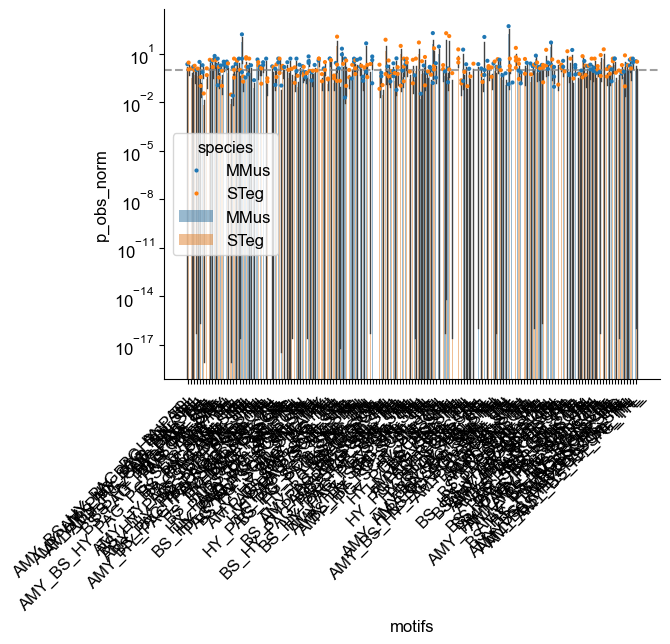

In [248]:

dot_bar_plot(pt_motifs_df_select, xaxis="motifs", yaxis="p_obs_norm",
             hueaxis="species", order = fc_order)
plt.yscale("log")
plt.axline((0,1), (1,1), color="gray", linestyle="--", alpha=0.75)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  # plot unity line


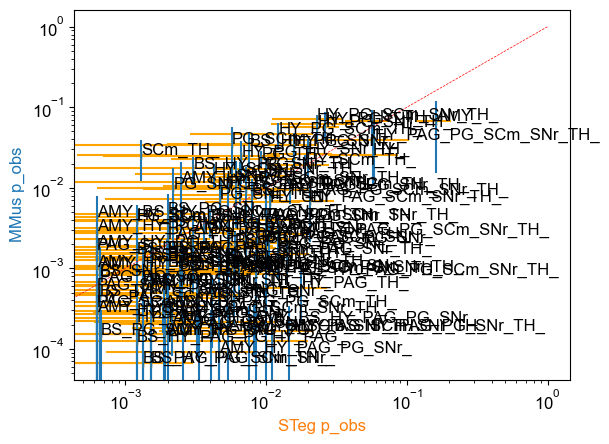

/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite val

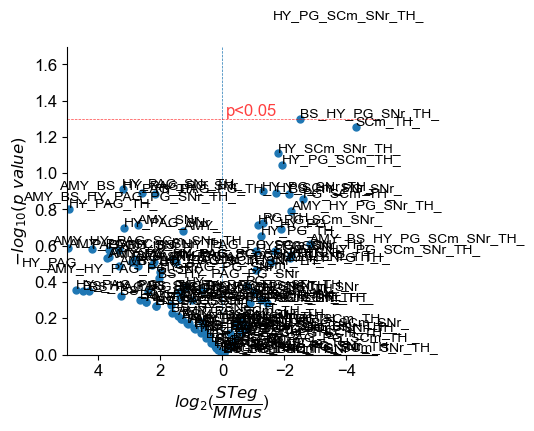

In [249]:

# scatterplot
stvmm_area_scatter(pt_motifs_df, to_plot="p_obs", groupby="motifs", log=True)
plt.show()
# volcano plot
ttest = proportion_ttest(pt_motifs_df, to_plot="p_obs", groupby="motifs")
plot_volcano(ttest, labels="motifs", p_01=False, xlim=(5,-5), legend_loc=None)
plt.show()


## concatenated data

In [251]:
mm_pt_all = mm_pt_all.reset_index(drop=True)
st_pt_all = st_pt_all.reset_index(drop=True)
pt_all = [mm_pt_all, st_pt_all]
pt_species = ["MMus", "STeg"]

In [252]:
plot_areas = plot_areas = ['TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']

# Estimate n-totals
n_totals = [estimate_n_total(pt_all[i], plot_areas) for i in range(len(pt_all))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in pt_all]
motifs = n_obs_motifs[0].index

# convert to proportions
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in pt_all]

motif_strings = TF_to_motifs(motifs)

# put into dataframe
pt_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":pt_all[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "species":pt_species[i]})
    pt_motifs_df.append(df)
pt_motifs_df = pd.concat(pt_motifs_df).reset_index(drop=True)
pt_motifs_df


,motifs,n_shape,n_total,n_obs,p_obs,p_calc,species
0,TH_,9259,9306,0,0.000000,0.011545,MMus
1,HY_,9259,9306,205,0.022029,0.012275,MMus
2,AMY_,9259,9306,446,0.047926,0.000431,MMus
3,SNr_,9259,9306,144,0.015474,0.005529,MMus
4,SCm_,9259,9306,166,0.017838,0.004459,MMus
...,...,...,...,...,...,...,...
505,AMY_BS_HY_PAG_PG_SCm_TH_,981,989,2,0.002022,0.000912,STeg
506,BS_HY_PAG_PG_SCm_SNr_TH_,981,989,8,0.008089,0.001231,STeg
507,AMY_BS_PAG_PG_SCm_SNr_TH_,981,989,10,0.010111,0.001025,STeg
508,AMY_BS_HY_PAG_PG_SCm_SNr_,981,989,6,0.006067,0.000804,STeg


In [254]:
print([df.shape[0] for df in pt_all])
print(n_totals)

[9259, 981]
[9306, 989]


In [276]:
# only keep motifs that are not 0 in mmus - don't need averages as only 1 observation
mm = pt_motifs_df[pt_motifs_df["species"]=="MMus"]
mm_n0 = mm[mm["p_obs"]>0]
keep_motifs = list(mm_n0["motifs"])
pt_motifs_df_select = pt_motifs_df[pt_motifs_df["motifs"].isin(keep_motifs)]
pt_motifs_df_select = pt_motifs_df_select.reset_index(drop=True)

# calculate fc and rank order
mm_select = pt_motifs_df_select[pt_motifs_df_select["species"]=="MMus"].reset_index(drop=True)
st_select = pt_motifs_df_select[pt_motifs_df_select["species"]=="STeg"].reset_index(drop=True)
p_obs_fc = st_select["p_obs"]/mm_select["p_obs"]
p_obs_fc.index = mm_select["motifs"]
fc_order = p_obs_fc.sort_values(ascending=False).index
fc_order

Index(['AMY_BS_HY_PAG_PG_SNr_TH_', 'AMY_HY_PAG_SCm_SNr_TH_',
       'AMY_PG_SCm_SNr_TH_', 'AMY_HY_PAG_PG_SNr_', 'AMY_BS_HY_PAG_PG_SNr_',
       'HY_PAG_', 'AMY_PG_SNr_', 'AMY_HY_', 'AMY_BS_HY_PAG_PG_SCm_SNr_TH_',
       'PAG_PG_SNr_',
       ...
       'AMY_HY_PG_SNr_', 'BS_PAG_PG_SCm_TH_', 'AMY_HY_PG_SCm_',
       'AMY_BS_HY_PG_', 'AMY_SNr_TH_', 'BS_HY_TH_', 'BS_HY_PG_SCm_SNr_',
       'AMY_BS_HY_PG_SNr_TH_', 'BS_HY_PG_SCm_SNr_TH_',
       'AMY_HY_PAG_PG_SCm_SNr_'],
      dtype='object', name='motifs', length=149)

In [279]:
# add column where norm p_obs by mmus p_obs average
mmus_pobs = mm_select["p_obs"]
mmus_pobs.index = mm_select["motifs"]
for i in range(pt_motifs_df_select.shape[0]):
    motif = pt_motifs_df_select.loc[i, "motifs"]
    p_obs = pt_motifs_df_select.loc[i, "p_obs"]
    norm = mmus_pobs[motif]
    pt_motifs_df_select.loc[i,"p_obs_norm"] = p_obs/norm
pt_motifs_df_select


,motifs,n_shape,n_total,n_obs,p_obs,p_calc,species,p_obs_norm
0,HY_,9259,9306,205,0.022029,0.012275,MMus,1.000000
1,AMY_,9259,9306,446,0.047926,0.000431,MMus,1.000000
2,SNr_,9259,9306,144,0.015474,0.005529,MMus,1.000000
3,SCm_,9259,9306,166,0.017838,0.004459,MMus,1.000000
4,PG_,9259,9306,144,0.015474,0.009707,MMus,1.000000
...,...,...,...,...,...,...,...,...
293,AMY_HY_PAG_PG_SCm_SNr_TH_,981,989,19,0.019211,0.004139,STeg,10.516505
294,AMY_BS_HY_PG_SCm_SNr_TH_,981,989,1,0.001011,0.001277,STeg,0.348500
295,AMY_BS_HY_PAG_PG_SNr_TH_,981,989,18,0.018200,0.001809,STeg,169.371082
296,BS_HY_PAG_PG_SCm_SNr_TH_,981,989,8,0.008089,0.001231,STeg,0.710151


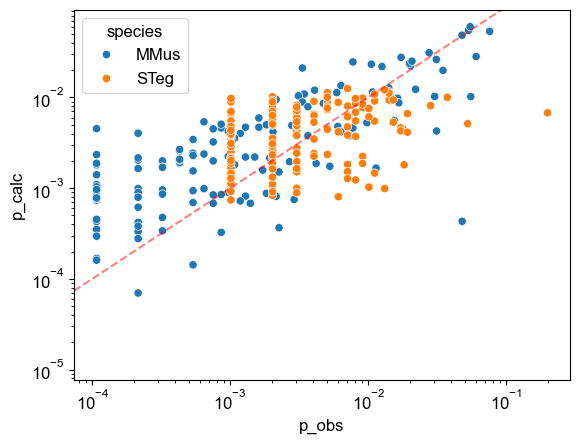

In [296]:
sns.scatterplot(pt_motifs_df, x="p_obs", y="p_calc", hue="species")
plt.xscale("log")
plt.yscale("log")
plt.axline((0.001,0.001), (0.01,0.01), color="red", linestyle="--", alpha=0.5)
plt.show()

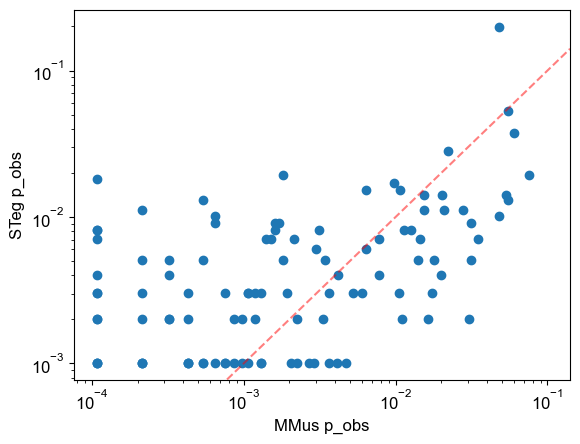

In [292]:
pivot = pt_motifs_df_select.pivot(columns="species", values="p_obs", index="motifs")
plt.scatter(pivot["MMus"], pivot["STeg"])
plt.xlabel("MMus p_obs")
plt.ylabel("STeg p_obs")
plt.xscale("log")
plt.yscale("log")
plt.axline((0.01, 0.01), (0.1,0.1), color="red", linestyle="--", alpha=0.5)
plt.show()

<Axes: xlabel='motifs', ylabel='p_obs'>

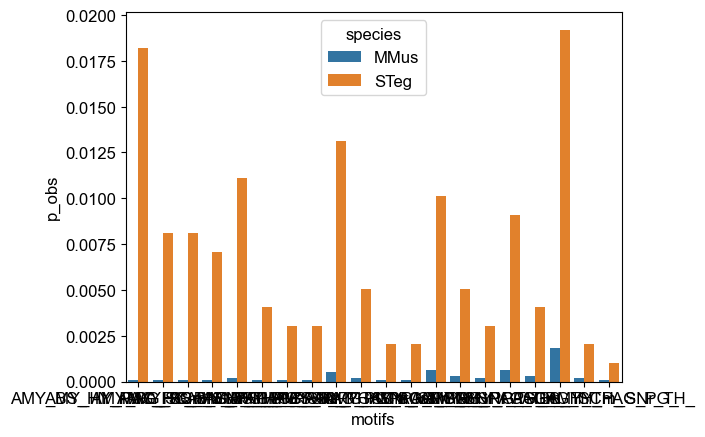

In [285]:
n=50

fc_order20 = fc_order[:50]

plot20 = pt_motifs_df_select[pt_motifs_df_select["motifs"].isin(fc_order20)]
sns.barplot(plot20, x="motifs", y="p_obs", hue="species", order=fc_order20)

In [301]:
# simulations
# generate simulated data
sim_avgs = []
sim_stds = []
for i in range(len(pt_all)):
    foo, shuffle_prob_reps = motif_simulation(pt_all[i], adjust_total=True, 
                                              plot_areas=plot_areas)
    shuffled_array = np.array(shuffle_prob_reps)
    sim_avgs.append(shuffled_array.mean(axis=0))
    sim_stds.append(shuffled_array.std(axis=0))
print(sim_avgs)
print(sim_avgs)

KeyboardInterrupt: 

In [ ]:


it_motifs_df["p_sim"] = np.array(sim_avgs).flatten()
it_motifs_df["p_sim_std"] = np.array(sim_stds).flatten()
it_motifs_df
# plot calc vs. sim
# sns.lineplot(it_motifs_df, x="p_obs", y="p_sim", hue="species")
# sns.lineplot(it_motifs_df, x="p_obs", y="p_calc", hue="species")
mm = it_motifs_df[it_motifs_df["species"]=="MMus"]
st = it_motifs_df[it_motifs_df["species"]=="STeg"]

sns.regplot(mm, x="p_calc", y="p_sim")
sns.regplot(st, x="p_calc", y="p_sim")